<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/ALIGNN_Sc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook that uses JARVIS-DFT data to train an ALIGNN model for prediction of Tc for BCS superconductors:

Refs:

https://www.nature.com/articles/s41524-022-00933-1

https://pubs.acs.org/doi/full/10.1021/acs.nanolett.2c04420

https://pubs.acs.org/doi/10.1021/acs.jpclett.3c01260


In [1]:
%%time
!pip install -q dgl==1.0.1+cu117 -f https://data.dgl.ai/wheels/cu117/repo.html
!pip install -q alignn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.8/269.8 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.1/802.1 kB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

# For this example, we only use 3 epochs and a batch size of 2. For production-level calculations this will be increased.

In [2]:
import json

data = {
    "version": "112bbedebdaecf59fb18e11c929080fb2f358246",
    "dataset": "user_data",
    "target": "target",
    "atom_features": "cgcnn",
    "neighbor_strategy": "k-nearest",
    "id_tag": "jid",
    "random_seed": 123,
    "classification_threshold": None,
    "n_val": None,
    "n_test": None,
    "n_train": None,
    "train_ratio": 0.8,
    "val_ratio": 0.1,
    "test_ratio": 0.1,
    "target_multiplication_factor": None,
    "epochs": 3,
    "batch_size": 2,
    "weight_decay": 1e-05,
    "learning_rate": 0.001,
    "filename": "sample",
    "warmup_steps": 2000,
    "criterion": "mse",
    "optimizer": "adamw",
    "scheduler": "onecycle",
    "pin_memory": False,
    "save_dataloader": False,
    "write_checkpoint": True,
    "write_predictions": True,
    "store_outputs": True,
    "progress": True,
    "log_tensorboard": False,
    "standard_scalar_and_pca": False,
    "use_canonize": True,
    "num_workers": 0,
    "cutoff": 8.0,
    "max_neighbors": 12,
    "keep_data_order": False,
    "model": {
        "name": "alignn",
        "alignn_layers": 4,
        "gcn_layers": 4,
        "atom_input_features": 92,
        "edge_input_features": 80,
        "triplet_input_features": 40,
        "embedding_features": 64,
        "hidden_features": 256,
        "output_features": 1,
        "link": "identity",
        "zero_inflated": False,
        "classification": False
    }
}

file_path = "config.json"

with open(file_path, "w") as json_file:
    json.dump(data, json_file)

# Generate the dataset from JARVIS-DFT database of 1k superconducting materials (electron-phonon coupling calculations): https://www.nature.com/articles/s41524-022-00933-1

In [3]:
"""Module to generate example dataset."""
from jarvis.db.figshare import data as jdata
from jarvis.core.atoms import Atoms
outdir = "./"
dft_3d = jdata("dft_3d")
prop = "Tc_supercon"  # "optb88vdw_bandgap"
# max_samples = 50
f = open("id_prop.csv", "w")
count = 0
for i in dft_3d:
    atoms = Atoms.from_dict(i["atoms"])
    jid = i["jid"]
    poscar_name = "POSCAR-" + jid + ".vasp"
    target = i[prop]
    if target != "na":
        atoms.write_poscar(poscar_name)
        f.write("%s,%6f\n" % (poscar_name, target))
        # count += 1
        # if count == max_samples:
        #    break
f.close()

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699


100%|██████████| 40.8M/40.8M [00:03<00:00, 10.9MiB/s]


Loading the zipfile...
Loading completed.


# Train ALIGNN model on DFT dataset

In [4]:
%%time
!train_folder.py --root_dir "./" --config "config.json" --output_dir=temp

DGL backend not selected or invalid.  Assuming PyTorch for now.
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
fatal: not a git repository (or any of the parent directories): .git
MAX val: 33.470224
MIN val: 0.0
MAD: 3.468769594982508
Baseline MAE: 3.422002367207025
data range 33.470224 0.0
100% 846/846 [00:19<00:00, 42.58it/s]
df                                                  atoms                       jid    target
0    {'lattice_mat': [[-0.0, 3.1492533201194153, 3....   POSCAR-JVASP-39970.vasp  0.033714
1    {'lattice_mat': [[4.768060710893495, 0.0042661...  POSCAR-JVASP-100639.vasp  0.056265
2    {'lattice_mat': [[2.867231202877823, 0.0, 0.0]...   POSCAR-JVASP-14652.vasp  4.015619
3    {'lattice_mat': [[4.066140997541031, 0.0, 0.0]...   POSCAR-JVASP-17473.vasp  0.057916
4    {'lattice_mat': [[1.601197304104502, -2.773354...    

# The results are contained in the temp folder. The checkpoint_3.pt file is the trained model for the 3rd and final epoch.

In [5]:
!ls temp

best_model.pt	 history_train.json	  prediction_results_test_set.csv   val_data_data_range
checkpoint_2.pt  history_val.json	  prediction_results_train_set.csv
checkpoint_3.pt  ids_train_val_test.json  test_data_data_range
config.json	 mad			  train_data_data_range


# Plot the predicted results vs. target (DFT) results for the test set and training set.

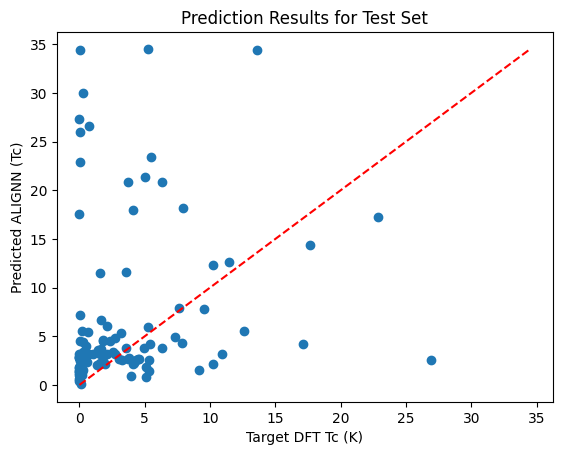

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
data = pd.read_csv("temp/prediction_results_test_set.csv", skiprows=1)

x = data.iloc[:, 1]  # Second column
y = data.iloc[:, 2]  # Third column
line_values = np.linspace(min(x.min(), y.min()), max(x.max(), y.max()), 100)
plt.plot(line_values, line_values, label="x=y Reference", color="r", linestyle="--")
plt.scatter(x, y)
plt.xlabel("Target DFT Tc (K)")
plt.ylabel("Predicted ALIGNN (Tc)")
plt.title("Prediction Results for Test Set")
plt.show()

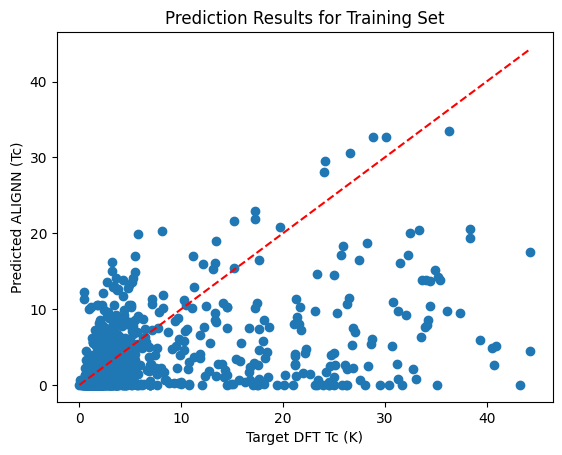

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
data = pd.read_csv("temp/prediction_results_train_set.csv", skiprows=1)

x = data.iloc[:, 0]  # Second column
y = data.iloc[:, 1]  # Third column
line_values = np.linspace(min(x.min(), y.min()), max(x.max(), y.max()), 100)
plt.plot(line_values, line_values, label="x=y Reference", color="r", linestyle="--")
plt.scatter(x, y)
plt.xlabel("Target DFT Tc (K)")
plt.ylabel("Predicted ALIGNN (Tc)")
plt.title("Prediction Results for Training Set")
plt.show()

# Load our trained ALIGNN model for epoch 3  

In [8]:
from alignn.models.alignn import ALIGNN, ALIGNNConfig
import torch
output_features =  1
filename = 'temp/checkpoint_3.pt'
device = "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
model = ALIGNN(ALIGNNConfig(name="alignn", output_features=output_features))
model.load_state_dict(torch.load(filename, map_location=device)["model"])
model.eval()

ALIGNN(
  (atom_embedding): MLPLayer(
    (layer): Sequential(
      (0): Linear(in_features=92, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
    )
  )
  (edge_embedding): Sequential(
    (0): RBFExpansion()
    (1): MLPLayer(
      (layer): Sequential(
        (0): Linear(in_features=80, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
    )
    (2): MLPLayer(
      (layer): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
    )
  )
  (angle_embedding): Sequential(
    (0): RBFExpansion()
    (1): MLPLayer(
      (layer): Sequential(
        (0): Linear(in_features=40, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.

# In this section, we screen for new potential superconductors outside of the training set. Since hydrides have attracted recent attention, we can screen for potential superconductors that contain H.

In [ ]:
from jarvis.db.figshare import data

dft_3d = data('dft_3d')

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


In [ ]:
df=pd.DataFrame(dft_3d)

In [ ]:
print (df.columns, len(df.columns))

Index(['jid', 'spg_number', 'spg_symbol', 'formula',
       'formation_energy_peratom', 'func', 'optb88vdw_bandgap', 'atoms',
       'slme', 'magmom_oszicar', 'spillage', 'elastic_tensor',
       'effective_masses_300K', 'kpoint_length_unit', 'maxdiff_mesh',
       'maxdiff_bz', 'encut', 'optb88vdw_total_energy', 'epsx', 'epsy', 'epsz',
       'mepsx', 'mepsy', 'mepsz', 'modes', 'magmom_outcar', 'max_efg',
       'avg_elec_mass', 'avg_hole_mass', 'icsd', 'dfpt_piezo_max_eij',
       'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric',
       'dfpt_piezo_max_dielectric_electronic',
       'dfpt_piezo_max_dielectric_ionic', 'max_ir_mode', 'min_ir_mode',
       'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact', 'ncond',
       'pcond', 'nkappa', 'pkappa', 'ehull', 'Tc_supercon', 'dimensionality',
       'efg', 'xml_data_link', 'typ', 'exfoliation_energy', 'spg', 'crys',
       'density', 'poisson', 'raw_files', 'nat', 'bulk_modulus_kv',
       'shear_modulus_gv', 'mbj_bandgap', 'hse_ga

In [ ]:
df1 = df[['optb88vdw_bandgap','magmom_outcar', 'ehull', 'atoms', 'jid']].replace('na',np.nan).dropna()

In [ ]:
from jarvis.core.atoms import Atoms
def has_element(atoms_dict = {}, my_element = 'H'):
    atoms = Atoms.from_dict(atoms_dict)
    elements = atoms.elements
    if my_element in elements:
        return True
    else:
        return np.nan

df1['el'] = df1['atoms'].apply(lambda x: has_element(atoms_dict = x, my_element = 'H'))
df1['formula'] = df1['atoms'].apply(lambda x: Atoms.from_dict(x).composition.reduced_formula)

In [ ]:
df2 = df1.dropna()

We establish our screening criteria below

In [ ]:
df2[(df2['optb88vdw_bandgap'] <= .1) & (df2['ehull'] <= .2) & (df2['magmom_outcar'] <= 0.05)]

,optb88vdw_bandgap,magmom_outcar,ehull,atoms,jid,el,formula
531,0.0,0.0,0.1306,"{'lattice_mat': [[-1.7794851791134307, -3.0829...",JVASP-91703,True,ErH3
646,0.0,0.0,0.1689,"{'lattice_mat': [[5.344648361353434, 3.2291114...",JVASP-88522,True,BaAl3P2H2O14
963,0.0,0.0,0.1634,"{'lattice_mat': [[2.833826211429782, 0.0, 0.0]...",JVASP-90047,True,Ti4H3Pd2
1090,0.0,0.0,0.0246,"{'lattice_mat': [[3.6761599003449548, 4.8e-15,...",JVASP-18464,True,Li4H4Rh
1482,0.0,0.0,0.1435,"{'lattice_mat': [[0.0, 0.0, -2.836889239583801...",JVASP-91661,True,TiFeH2
...,...,...,...,...,...,...,...
75617,0.0,0.0,0.0000,"{'lattice_mat': [[0.0, 3.8037306146989485, 3.8...",JVASP-157630,True,Sr2H6Pd
75618,0.0,0.0,0.0000,"{'lattice_mat': [[-0.0, 3.6260655995798476, 3....",JVASP-157568,True,Ca2H6Pt
75673,0.0,0.0,0.0000,"{'lattice_mat': [[-0.0, 3.490551561899994, 3.4...",JVASP-157789,True,Ca2CoH6
75709,0.0,0.0,0.0000,"{'lattice_mat': [[0.0, 3.942091802081512, 3.94...",JVASP-157683,True,Ba2NiH6


JVASP-157789 is a potential superconductor, let's see what our trained model predicts and what the available ALIGNN pretrained model (300 epochs) predicts

In [ ]:
from jarvis.db.figshare import get_jid_data
dat = get_jid_data(jid="JVASP-157789", dataset="dft_3d")

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


In [ ]:
atoms = Atoms.from_dict(dat["atoms"])

In [ ]:
atoms.write_poscar('POSCAR-JVASP-157789')

In [ ]:
import sys
from alignn.models.alignn import ALIGNN, ALIGNNConfig
import torch
from jarvis.core.atoms import Atoms
from alignn.graphs import Graph

output_features = 1
filename = 'temp/checkpoint_3.pt'
device = "cpu"

if torch.cuda.is_available():
    device = torch.device("cuda")

model = ALIGNN(ALIGNNConfig(name="alignn", output_features=output_features))
model.load_state_dict(torch.load(filename, map_location=device)["model"])
model.eval()

cutoff = 8.0
model = model.to(device)
max_neighbors = 12

jids = ["POSCAR-JVASP-157789"]

# Save the current standard output (e.g., the console) to a variable
original_stdout = sys.stdout

for i in jids:
    atoms = Atoms.from_poscar(i)
    g, lg = Graph.atom_dgl_multigraph(
        atoms, cutoff=float(cutoff), max_neighbors=max_neighbors
    )
    out_data = (
        model([g.to(device), lg.to(device)])
        .detach()
        .cpu()
        .numpy()
        .flatten()
        .tolist()
    )
    print(i, out_data[0])



POSCAR-JVASP-157789 5.109636306762695


In [ ]:
!pretrained.py --model_name jv_supercon_tc_alignn --file_format poscar --file_path POSCAR-JVASP-157789

Using chk file jv_supercon_tc_alignn/checkpoint_200.pt from  ['jv_supercon_tc_alignn/checkpoint_200.pt']
Path /usr/local/bin/jv_supercon_tc_alignn.zip
Config /content/jv_supercon_tc_alignn/config.json
Predicted value: jv_supercon_tc_alignn POSCAR-JVASP-157789 [3.498167037963867]


As an excercise, try to find potential superconductors in the JARVIS database and screen them with the ALIGNN model for Tc